Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [157]:
NAME = "Hegyi Gáspár András"
COLLABORATORS = ""

---

# Assignment: Naïve Bayes Classifier

In this assignment, you will implement the Naïve Bayes classifier and compare it to that one implemented `scikit-learn` module. The goal is to investigate the influence of Laplace correction on the classification results for the Naïve Bayes classifier.

As a sample dataset, we will use the MNIST dataset of handwritten digits quantized into vectors of length 784, where each element of a vector is the gray level of the corresponding picture pixel. The original pictures have dimensions 28$\times$28. All vectors contain only pixels with three possible values: 0,1,2. The value 2 indicates a black pixel, the value 0 corresponds to a white pixel, and the value 1 corresponds to a gray pixel.

The file `MNIST3_dataset.npz` with the dataset can be downloaded from Moodle together with this notebook. 

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [159]:
# in the load method the parameter allow_pickle must 
# be set to True for unpacking the data
npzfile = np.load('MNIST3_v1_dataset.npz', allow_pickle=True)
npzfile.files

['X_train', 'X_validate', 'X_test', 'y_train', 'y_validate', 'y_test']

The arrays `X_train` and `y_train` contain training input data and true classes. The arrays `X_validate` and `y_validate` contain validation input data and true classes. The arrays `X_test` and `y_test` contain test inputs and true labels. E.g., let us inspect the 34th test sample.

True label 7


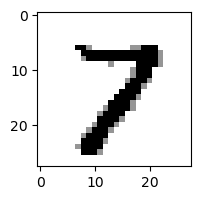

In [160]:
s = 34
plt.figure(figsize=(2,2))
plt.imshow(npzfile['X_test'][s].reshape(28,28), cmap='Greys')
y_test = npzfile['y_test']
print('True label',y_test[s])

You should implement your own Naïve Bayes classifier for classifying the handwritten digits. For that, you **must not use any classifier from another toolbox or library**. You should implement the following two functions:
* `NBTrain` for training a Naïve Bayes classifier with a Laplace correction, and
* `NBClassify` for classification.

After implementing the functions, you should test your classifier on the test 
set of handwritten digits. Below you will find a detailed description of the functions you should implement and tests you should perform.

## Task 1: Implement the function `NBTrain()`

The first function is 

    NBTrain(Pat, PatClass, FNum, CNum, LC=0)
    
where 
* `Pat` are training patterns stored in a two-dimensional array of integers with values between 0 and `FNum-1`,
* `PatClass` are true classes of the patterns in the array `Pat`; that is, `PatClass[i]` is the true class for the pattern `Pat[i]`,
* `FNum`is the number of possible values for a feature, the features can have values between 0 and `FNum-1` only, we assume `FNum` $\le10$,
* `CNum` is the number of classes, `PatClass` can contain only values between 0 and `CNum-1` (we assume `CNum` $\le 20$), and
* `LC` is the value of Laplace correction.

Function `NBTrain` should return a pair `(B,P)` of tables:
* `B` is a three-dimensional array, where `B[f,i,c]` is the **logarithm** of the probability that a pattern with value `f` in feature `i` is classified into the class `c`. For computing this conditional probability, you should use Laplace correction in the following form 

$B[f,i,c] = \log\frac{\text{the number of pattern with classification } c \text{ and value } f \text{ in the element } i \text{ of the pattern} + LC}{\text{the number of patterns from class } c + FNum\cdot LC}$

*  `P` is an array of log priors &ndash; **logarithms** of the estimates of apriori probabilities for all classes (without the Laplace correction)

$$P[c] = \log \frac{\text{the number of patterns classified into class } c}{\text{the number of all patterns}}\ .$$

In [161]:
def NBTrain(Pat, PatClass, FNum, CNum, LC=0):
    # the function computes two tables for the Naïve Bayes classifier
    # Parameters:
    #    Pat      training patterns stored in a two-dimensional 
    #             numpy array of integers with values between 0 and FNum-1
    #    PatClass true classes of the patterns in the array Pat, 
    #             integers between 0 to CNum-1
    #    FNum     the number of possible values for a feature, 
    #             the features can have values between 0 and FNum-1
    #    CNum     the number of classes
    #    LC       the value (float) of Laplace correction
    # Returns a pair (B,P) of tables:
    #    B        a three-dimensional array, where B[f,i,c] is the 
    #             **base-2 logarithm** of the probability that a pattern with value f
    #             in feature i is classified into the class c. 
    #             For computing this conditional probability, the Laplace 
    #             correction LC should be used 
    #    P        an array of log priors; P[c] is the (base-2 logarithm) of the prior
    #             probability that a sample will be from the class c
    numEntries = Pat.shape[0]
    numFeatures = Pat.shape[1]
    counts = np.zeros((FNum,numFeatures,CNum),dtype = np.float64)
    classCounts = np.zeros(CNum,dtype=np.float64)

    for c,element in enumerate(Pat):
        elementClass = PatClass[c]
        classCounts[elementClass]+=1 #Count the specific class
        classIndices = np.repeat(elementClass,numFeatures)
        featureIndices = np.arange(numFeatures)
        np.add.at(counts,(element,featureIndices,classIndices),1)
    priors = np.log2(classCounts/numEntries)

    counts += LC
    classCounts += FNum*LC
    return  np.log2(counts/classCounts),priors
    

Let us try the implementation on a tiny dataset of three samples with two attributes:

Attr1 |	Attr2 |	Class
------|-------|------
0 |     0 |   0
1 |     0 |   0   
2 |     1 |   1

The following cell will test your implementation of `NBTrain`, including several **hidden tests** (you can obtain **3 points**).

*Note: Warning `RuntimeWarning: divide by zero encountered in log ...`  is O.K.*, but you can turn it off by calling

    np.seterr(divide = 'ignore')

and back

    np.seterr(divide = 'warn') 

In [162]:
X = np.array([[0,0],
              [1,0],
              [2,1]])
y = np.array([0,0,1])

B, P = NBTrain(X, y, 3, 2, LC=0)
print(f"\n{B=}\n{P=}")
assert np.allclose(B[1], np.array([[    -1., -np.inf],
                                   [-np.inf,      0.]]))
assert np.allclose(P, np.array([-0.5849625, -1.5849625]))

B, P = NBTrain(X, y, 3, 2, LC=1)
print(f"\n{B=}\n{P=}")
assert np.allclose(B[2], np.array([[-2.32192809, -1.        ],
                                   [-2.32192809, -2.        ]]))
assert np.allclose(P, np.array([-0.5849625, -1.5849625]))



B=array([[[ -1., -inf],
        [  0., -inf]],

       [[ -1., -inf],
        [-inf,   0.]],

       [[-inf,   0.],
        [-inf, -inf]]])
P=array([-0.5849625, -1.5849625])

B=array([[[-1.32192809, -2.        ],
        [-0.73696559, -2.        ]],

       [[-1.32192809, -2.        ],
        [-2.32192809, -1.        ]],

       [[-2.32192809, -1.        ],
        [-2.32192809, -2.        ]]])
P=array([-0.5849625, -1.5849625])


C:\Users\hgand\AppData\Local\Temp\ipykernel_21928\3793682572.py:36: RuntimeWarning: divide by zero encountered in log2
  return  np.log2(counts/classCounts),priors


## Task 2: Implement the function `NBClassify()`

The second function 

    NBClassify(Pat, B, P)

computes the classification of the patterns `Pat` based on tables `B` and `P` produced by the function `NBTrain` and using the method of Naïve Bayes classifier. Its parameters are
* `Pat` is a two-dimensional array of patterns (each row of `Pat` is one pattern),
* `B` is a three-dimensional array of floats - the first array computed by `NBTrain`, and
* `P` is a vector of floats - the second array computed by `NBTrain`.

The function returns a vector containing predicted classes for all patterns from `Pat`.

In the implementation, you should use a logarithm, as otherwise, by computing products of a large number of values less than one, the accuracy can be lost.

In [163]:
def NBClassify(Pat, B, P):
    # using the method of Naïve Bayes classifier, computes 
    # the classification of the patterns Pat 
    # based on tables B and P produced by the function NBTrain
    # Parameters:
    #   Pat a two-dimensional array of patterns (each row of Pat is one pattern),
    #   B   a three-dimensional array of floats - the first array computed by NBTrain, and
    #   P   a vector of floats - the second array computed by NBTrain.
    # Returns: a vector containing predicted classes for all patterns from Pat.
    # 1. Calculate the probabilities for the entry as a sum of logarithms for all possible classes
    # 2. Take power of the logs
    # 3. Find the maximum value (that will be the class the entry belongs to)
    numClasses = P.shape[0]
    numEntries = Pat.shape[0]
    numFeatures = Pat.shape[1]
    predicts = np.zeros((numEntries,numClasses),dtype = np.float64)

    featureIndices = np.arange(numFeatures)
    for i,entry in enumerate(Pat):
        predicts[i] += P + np.sum(B[entry,featureIndices],axis=0)

    return np.argmax(predicts,axis=1)

In the following cell, your implemenation will be tested using also **hidden tests**. Do not edit the cell. You can obtain **3 points** for your implementation.  

In [164]:
B, P = NBTrain(npzfile['X_train'], npzfile['y_train'], 3, 10, 1)
print(P)
X_train = npzfile['X_train']
c = NBClassify(npzfile['X_train'],B,P)
print(c)
print('True classes',npzfile['y_train'])
print(f"Accuracy: {np.sum(c == npzfile['y_train'])/ c.shape[0]}")


[-3.33963722 -3.14586069 -3.33235307 -3.28461616 -3.3623063  -3.47329013
 -3.34022154 -3.26395803 -3.35934206 -3.33963722]
[9 5 1 ... 0 0 4]
True classes [8 5 1 ... 0 0 4]
Accuracy: 0.8366


In [165]:
#My testing whether the scikit implementation does better than mine with the same Laplace smoothing
from sklearn.naive_bayes import CategoricalNB

nb = CategoricalNB()
nb.fit(npzfile["X_train"],npzfile["y_train"])
results = nb.predict(npzfile["X_train"])
print(f"Accuracy: {np.sum(results == npzfile['y_train'])/ results.shape[0]}")

Accuracy: 0.83666


## Task 3: Find the best classifier

There are two sub-tasks here:

1. Calculate the error of the classifier on the validation set `X_validate` and the test set `X_test` for different Naïve bayes classifiers trained on `X_train` with different values of Laplace correction `LC` = 0, 0.00001, 0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.1, 0.2, 0.4, 1. For which of these Laplace correction values is the error on the validation set minimal?

3. Describe the errors made by your best obtained classifier.

Implement the following function that selects the value of Laplace correction from the given list for which the accuracy of the classifier on the validation set is maximal. The function should return the selected Laplace correction and a two-dimensional array with rows of the form

(*lc*, *train_a*, *validate_a*, *test_a*)

where 
* *lc* is a value of Laplace correction from the given list,
* *train_a* is the accuracy of the Naïve Bayes classifier with the Laplace correction *lc* on the train set,
* *validate_a* is the accuracy of the Naïve Bayes classifier with the Laplace correction *lc* on the validation set,
* *train_a* is the accuracy of the Naïve Bayes classifier with the Laplace correction *lc* on the test set


In [166]:
def best_LC(X_train, y_train, X_validate, y_validate, X_test, y_test, FNum, CNum, lc_list=[0.0]):
    # Using NBTrain and NBClassify, find the value of Laplace correction from the list
    # lc_list for which the classifier trained on X_train with true classes y_train
    # has the highest accuracy on the validation set X_validate with true classes y_validate
    # Parameters:
    #   X_train    a two-dimensional numpy array of patterns (each row is one pattern),
    #   y_train    a one-dimensional numpy array of integers with correct classes for 
    #              the patterns in X_train,
    #   X_validate a two-dimensional numpy array of patterns (each row is one pattern),
    #   y_validate a one-dimensional numpy array of integers with correct classes for 
    #              the patterns in X_validate,
    #   FNum       the number of possible values for a feature, 
    #              the features can have values between 0 and FNum-1
    #   CNum       the number of classes
    #   LC_list    a list of values of Laplace correction
    # Returns:     one value from LC_list that is the best Laplace correction; 
    #              if the best accuracy is achieved for more than one Laplace correction
    #              from the list lc_list, the function returns the leftmost one in lc_list
    result = np.zeros((3,len(lc_list)))
    result = np.concatenate([np.array([lc_list]),result],axis=0)
    for c,lc in enumerate(lc_list):
        B,P = NBTrain(X_train,y_train,FNum,CNum,lc)
        predTrainClasses = NBClassify(X_train,B,P)
        predValClasses = NBClassify(X_validate,B,P)
        predTestClasses = NBClassify(X_test,B,P)
        accuracyTrain = np.sum(predTrainClasses == y_train)/ predTrainClasses.shape[0]
        accuracyVal = np.sum(predValClasses == y_validate)/ predValClasses.shape[0]
        accuracyTest = np.sum(predTestClasses == y_test)/ predTestClasses.shape[0]
        result[1,c]+=accuracyTrain
        result[2,c]+=accuracyVal
        result[3,c]+= accuracyTest

    return lc_list[np.min(np.argmax(result[2]))],result.T
    

In the following cell, the function `best_LC` will be tested, including **hidden tests** (you can obtain **2 points**). 

In [167]:
import pandas as pd

K = 20
X_train = npzfile['X_train'][:2 * K]
X_validate = npzfile['X_validate'][:K]
X_test = npzfile['X_test'][:K]
y_train = npzfile['y_train'][:2 * K]
y_validate = npzfile['y_validate'][:K]
y_test = npzfile['y_test'][:K]

best_lc, table = best_LC(X_train, y_train, X_validate, y_validate, X_test, y_test, 3, 10, lc_list=[0.0, 0.1, 0.5, 1.0])
print(f"The best Laplace correction for mini-dataset {best_lc}")

assert best_lc == 0.1
df = pd.DataFrame(table, columns=['Laplace correction', 'Train accuracy', 'Validation accuracy', 'Test accuracy'])
print(df)



The best Laplace correction for mini-dataset 0.1
   Laplace correction  Train accuracy  Validation accuracy  Test accuracy
0                 0.0            1.00                 0.05           0.15
1                 0.1            1.00                 0.45           0.45
2                 0.5            1.00                 0.40           0.30
3                 1.0            0.85                 0.35           0.25


C:\Users\hgand\AppData\Local\Temp\ipykernel_21928\3793682572.py:36: RuntimeWarning: divide by zero encountered in log2
  return  np.log2(counts/classCounts),priors


In the next cell, find the best Laplace correction for the complete dataset obtained from the file `MNIST3_v1_dataset.npz`(with respect to the accuracy on the validation set) to variable `lc` and the corresponding accuracy on the test set to variable `accuracy'. Use the list `lc_list = [0, 0.00001, 0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.1, 0.2, 0.4, 1]` as the set of possible values of the Laplace correction.

Additionally, print the table obtained from the corresponding call to `best_LC`. 

In [182]:
lc_list = [0.0, 0.00001, 0.0001, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.1, 0.2, 0.4, 1.0]

lc,table = best_LC(npzfile["X_train"],npzfile["y_train"],npzfile['X_validate'],npzfile['y_validate'],npzfile['X_test'],npzfile['y_test'],3,10,lc_list)

df = pd.DataFrame(table, columns=['Laplace correction', 'Train accuracy', 'Validation accuracy', 'Test accuracy'])
print(df)

accuracy =df['Test accuracy'].max()

C:\Users\hgand\AppData\Local\Temp\ipykernel_21928\3793682572.py:36: RuntimeWarning: divide by zero encountered in log2
  return  np.log2(counts/classCounts),priors


    Laplace correction  Train accuracy  Validation accuracy  Test accuracy
0              0.00000         0.84116               0.8337         0.8468
1              0.00001         0.83990               0.8357         0.8491
2              0.00010         0.83950               0.8358         0.8490
3              0.00050         0.83920               0.8357         0.8489
4              0.00100         0.83908               0.8354         0.8488
5              0.00200         0.83900               0.8354         0.8486
6              0.00500         0.83876               0.8354         0.8485
7              0.01000         0.83854               0.8353         0.8485
8              0.10000         0.83792               0.8352         0.8479
9              0.20000         0.83770               0.8350         0.8480
10             0.40000         0.83730               0.8345         0.8477
11             1.00000         0.83660               0.8339         0.8471


In the following cell, the values of `lc` and `accuracy` will be tested (**1 point**).

Take the best Naïve Bayes classifier for the complete dataset and plot the first 10 images with digits from the test set, for which the classifier made an error. For each image, print the classification computed by the classifier and the correct classification. 

Predicted Real
4 5
3 5
4 6
0 4
3 2
3 1
2 6
8 0
2 3
9 4


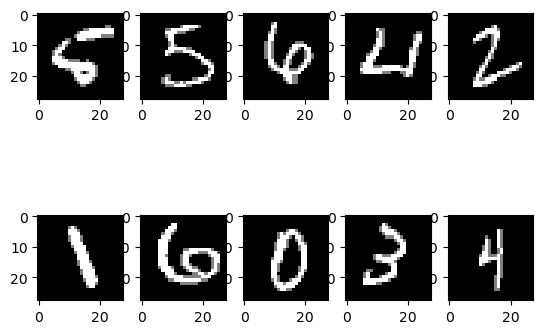

In [237]:
B,P = NBTrain(npzfile["X_train"],npzfile["y_train"],3,10,lc)
wrongClass = 0
fig,axs = plt.subplots(2,5)
print("Predicted Real")
for c,sample in enumerate(npzfile["X_test"]):
    c_pred = NBClassify(np.array([sample]),B,P)
    c_real = npzfile["y_test"][c]
    if c_pred[0]!=c_real:
        print(c_pred[0],c_real)
        axs[wrongClass//5,wrongClass%5].imshow(np.reshape(sample,(28,28)),cmap="gray")
        wrongClass+=1

    if(wrongClass==10):
        break

Try to explain the errors made by the classifier. (**1 point**)

I would say the error happens when the digit resembles another digit, and probably there is only a slight difference in the log likelihoods
between the real and the predicted class.

